In [1]:
import numpy as np

from squlearn.encoding_circuit import (
    PrunedEncodingCircuit,
    pruning_from_QFI,
    automated_pruning,
)
from squlearn.encoding_circuit import LayeredEncodingCircuit
from squlearn.util.qfi import get_quantum_fisher
from squlearn.util.executor import Executor

In [2]:
# Example uses statevector as backend
executor = Executor("statevector_simulator")

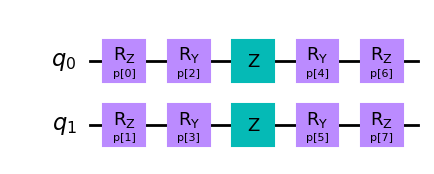

In [3]:
# Example for two qubits
nqubit = 2

# Generate and print the example pqc
pqc = LayeredEncodingCircuit.from_string("Rz(p)-Ry(p)-Z-Ry(p)-Rz(p)", nqubit, num_features=0)
pqc.draw("mpl")

In [4]:
# Generate random parameters
np.random.seed(0)
param = np.random.rand(pqc.num_parameters)

# Nicer numpy output
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Evaluate and print the Quantum Fisher Information Matrix
QFIM = get_quantum_fisher(pqc, [], param, executor)
print(QFIM)

[[ 0.     0.    -0.    -0.    -0.     0.     0.     0.   ]
 [ 0.     0.    -0.    -0.     0.     0.     0.     0.   ]
 [-0.    -0.     1.     0.    -1.    -0.    -0.    -0.   ]
 [-0.    -0.     0.     1.    -0.    -1.    -0.     0.   ]
 [-0.     0.    -1.    -0.     1.     0.     0.     0.   ]
 [ 0.     0.    -0.    -1.     0.     1.     0.     0.   ]
 [ 0.     0.    -0.    -0.     0.     0.     0.032  0.   ]
 [ 0.     0.    -0.     0.     0.     0.     0.     0.01 ]]


In [5]:
# Calculate and print the spectrum of the Quantum Fisher Information Matrix
V, D = np.linalg.eig(QFIM)
print(np.sort(V))

[-0.    -0.     0.     0.     0.01   0.032  2.     2.   ]


In [6]:
# Call the pruning routine and print the pruned parameters
red_gate = pruning_from_QFI(QFIM)
print(np.sort(red_gate))

[0 1 2 5]


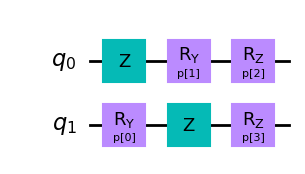

In [7]:
# Construct and print the pruned PQC
pruned_pqc = PrunedEncodingCircuit(pqc, red_gate)
pruned_pqc.draw("mpl")

Pruned parameters: [0 1 2 3]


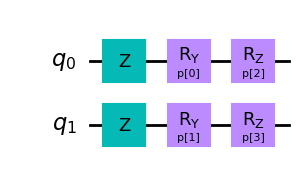

In [8]:
# Example for the automated pruning routine
pruned_pqc_auto = automated_pruning(pqc, executor)
pruned_pqc_auto.draw("mpl")